<a href="https://colab.research.google.com/github/LemmensJens/image_classification/blob/master/xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Detecting pneumonia in chest x-rays

In [0]:
pip install --upgrade tensorflow

     |████████████████████████████████| 86.3MB 112kB/s 
     |████████████████████████████████| 450kB 37.5MB/s 
     |████████████████████████████████| 3.8MB 20.3MB/s 
     |████████████████████████████████| 81kB 8.4MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.2 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalle

In [0]:
#import required libraries
import os, random, tensorflow, shutil
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
print(tensorflow.__version__)

2.0.0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#inspect train/test proportions
train_pneumonia_dir = '/content/drive/My Drive/Colab Notebooks/chest_xray/train/PNEUMONIA/'
train_normal_dir = '/content/drive/My Drive/Colab Notebooks/chest_xray/train/NORMAL/'

train_normal = os.listdir(train_normal_dir)
train_pneumonia = os.listdir(train_pneumonia_dir)

print(f"Normal: {len(train_normal)}")
print(f"Pneumonia: {len(train_pneumonia)}")

Normal: 2684
Pneumonia: 2684


In [0]:
#apply oversampling of underrepresented data to balance data
if len(train_normal) != len(train_pneumonia):
  for f in train_normal:
    shutil.copy(train_normal_dir+f, train_normal_dir+'copy_'+f)

  train_normal = os.listdir(train_normal_dir)

  print(f"Normal: {len(train_normal)}")
  print(f"Pneumonia: {len(train_pneumonia)}")

else:
  print("Data is balanced!")

Data is balanced!


In [0]:
#apply undersampling of overrepresented data to balance data
if len(train_normal) != len(train_pneumonia):
    
    train_pneumonia = random.sample(train_pneumonia, k=len(train_normal))

    for file in os.listdir(train_pneumonia_dir):
        if file not in train_pneumonia:
            os.remove(train_pneumonia_dir+file)
            
    train_pneumonia = os.listdir(train_pneumonia_dir)

    print(f"Normal: {len(train_normal)}")
    print(f"Pneumonia: {len(train_pneumonia)}")
    
else:
    print("Data is balanced!")

Data is balanced!


In [0]:
#calculate accuracy baseline of train set, output should always be 50%
train_baseline = len(train_normal)/(len(train_normal)+len(train_pneumonia))
print(f"Baseline: {round(train_baseline*100, 2)}% accuracy")

Baseline: 50.0% accuracy


In [0]:
#calculate accuracy baseline of test set
test_normal = os.listdir('/content/drive/My Drive/Colab Notebooks/chest_xray/test/NORMAL/')
test_pneumonia = os.listdir('/content/drive/My Drive/Colab Notebooks/chest_xray/test/PNEUMONIA/')

test_normal_cnt = 0
test_pneumonia_cnt = 0

for file in test_normal:
    test_normal_cnt += 1
for file in test_pneumonia:
    test_pneumonia_cnt += 1

if test_normal_cnt < test_pneumonia_cnt:
    test_baseline = test_pneumonia_cnt/(test_normal_cnt+test_pneumonia_cnt)
else:
    test_baseline = test_normal_cnt/(test_normal_cnt+test_pneumonia_cnt)

print(f"Baseline: {round(test_baseline*100, 2)}% accuracy")

Baseline: 62.5% accuracy


In [0]:
#define parameters
OPTIMIZER = Adam(lr=1e-4) #best lr according to lr_schedule
DROPOUT = .2
EPOCHS = 20
BATCH_SIZE = 32
STEPS_PER_EPOCH = 32
lr_schedule = LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 10))

In [0]:
#design model
model = Sequential([
    #first convolutional layer with pooling and dropout
    Conv2D(64, (3, 3), activation="relu", input_shape=(150, 150, 3)),
    Dropout(DROPOUT),
    MaxPooling2D(2, 2),
    #second convolutional layer with pooling and dropout
    Conv2D(64, (3, 3), activation="relu"),
    Dropout(DROPOUT),
    MaxPooling2D(2, 2),
    #third convolutional layer with pooling and dropout
    Conv2D(64, (3, 3), activation="relu"),
    Dropout(DROPOUT),
    MaxPooling2D(2, 2),
    #flatten
    Flatten(),
    #dense layer with dropout
    Dense(1024, activation="relu"),
    Dropout(DROPOUT),
    #output layer
    Dense(1, activation="sigmoid")
])          

#compile model
model.compile(
    optimizer=OPTIMIZER,
    loss='binary_crossentropy',
    metrics=['acc']
)

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 148, 148, 64)      1792      
_________________________________________________________________
dropout_27 (Dropout)         (None, 148, 148, 64)      0         
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 72, 72, 64)        36928     
_________________________________________________________________
dropout_28 (Dropout)         (None, 72, 72, 64)        0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 34, 34, 64)       

In [0]:
train_dir = '/content/drive/My Drive/Colab Notebooks/chest_xray/train/'

train_datagen = ImageDataGenerator(
    rescale=1/255,
    width_shift_range=.1,
    height_shift_range=.1,
    zoom_range=.1,
    rotation_range=10,
    brightness_range=[.9, 1.1]
)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        class_mode='binary',
        batch_size=BATCH_SIZE
)

Found 5366 images belonging to 2 classes.


In [0]:
test_dir = '/content/drive/My Drive/Colab Notebooks/chest_xray/test/'

test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        class_mode='binary', 
        batch_size=BATCH_SIZE
)

Found 624 images belonging to 2 classes.


In [0]:
#train model
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    verbose=1,
    validation_data=test_generator,
    #validation_split=.1, #validation set provided contained only 16 images
    #callbacks=[lr_schedule]
)

Epoch 1/20
32/32 [==============================] - 160s 5s/step - loss: 0.6938 - acc: 0.6201 - val_loss: 0.5727 - val_acc: 0.7885
Epoch 2/20
32/32 [==============================] - 154s 5s/step - loss: 0.4140 - acc: 0.8311 - val_loss: 0.4484 - val_acc: 0.7949
Epoch 3/20
32/32 [==============================] - 154s 5s/step - loss: 0.2970 - acc: 0.8809 - val_loss: 0.3449 - val_acc: 0.8558
Epoch 4/20
32/32 [==============================] - 152s 5s/step - loss: 0.3043 - acc: 0.8799 - val_loss: 0.3406 - val_acc: 0.8654
Epoch 5/20
32/32 [==============================] - 149s 5s/step - loss: 0.2752 - acc: 0.8925 - val_loss: 0.3693 - val_acc: 0.8285
Epoch 6/20
32/32 [==============================] - 158s 5s/step - loss: 0.2673 - acc: 0.8887 - val_loss: 0.3345 - val_acc: 0.8574
Epoch 7/20
32/32 [==============================] - 153s 5s/step - loss: 0.2715 - acc: 0.8887 - val_loss: 0.3304 - val_acc: 0.8574
Epoch 8/20
32/32 [==============================] - 155s 5s/step - loss: 0.2172 - a

[1e-07, 0.01, 0, 1]

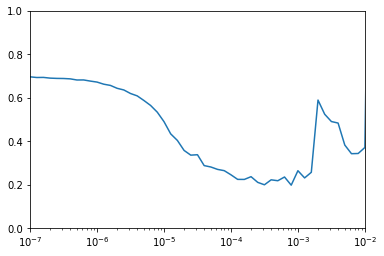

In [0]:
#visualize training loss for lr_schedule
#plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-7, 1e-2, 0, 1])

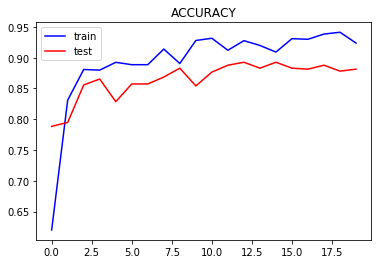

<Figure size 432x288 with 0 Axes>

In [0]:
#visualize train / test accuracy scores
train_acc = history.history['acc']
test_acc = history.history['val_acc']
n = len(train_acc)
epochs = range(n)

plt.plot(epochs, train_acc, 'b', label='train')
plt.plot(epochs, test_acc, 'r', label='test')
plt.title('ACCURACY')
plt.legend(loc=0)
plt.figure()

plt.show()

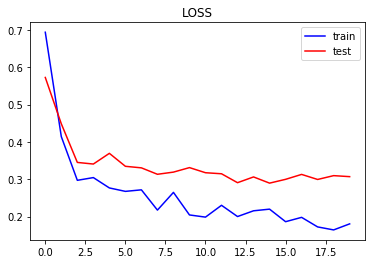

<Figure size 432x288 with 0 Axes>

In [0]:
#visualize train / test loss
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epochs = range(len(train_loss))

plt.plot(epochs, train_loss, 'b', label='train')
plt.plot(epochs, test_loss, 'r', label='test')
plt.title('LOSS')
plt.legend(loc=0)
plt.figure()

plt.show()